# Image segmentation, Feature vectors & CNNs

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Image segmentation

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(image, background):

    image = cv2.resize(image,(960, 540))
    background = cv2.cvtColor(cv2.resize(background,(960, 540)), cv2.COLOR_BGR2HSV)
    img = np.copy(image)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_green = np.array([36, 25, 25])
    upper_green = np.array([70,255,255])
    
    mask = cv2.inRange(img_hsv, lower_green, upper_green)
    
    mask1 = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    mask1 = cv2.morphologyEx(mask1, cv2.MORPH_DILATE, np.ones((3,3) ,np.uint8))
    
    mask2 = cv2.bitwise_not(mask1)
    res1 = cv2.bitwise_and(img_hsv,img_hsv,mask=mask2)
    
    res2 = cv2.bitwise_and(background, background, mask = mask1)
 
    #Generating the final output
    final_output = cv2.addWeighted(res1,1,res2,1,0)
    result = cv2.cvtColor(final_output, cv2.COLOR_HSV2BGR)

    return result

In [4]:
background = cv2.imread('images/frame2100.jpg')
output = 'images/video_out.mp4'

clip1 = VideoFileClip("images/video1.mp4").subclip(35,50)
clip = clip1.fl_image(lambda image: process_image(image, background=background))
%time clip.write_videofile(output, audio=False)

Moviepy - Building video images/video_out.mp4.
Moviepy - Writing video images/video_out.mp4



Moviepy - Done !
Moviepy - video ready images/video_out.mp4
Wall time: 2min 54s


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

**Image segmentation for Self-driving Cars**

https://colab.research.google.com/github/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/tutorial_driving_scene_segmentation.ipynb

## Features and corner detection

Last week we calculated image derivatives with a filter that allowed us to see strong intensity changes in different directions.

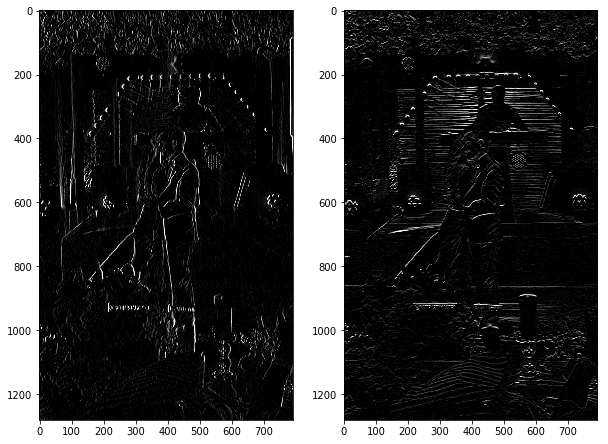

In [6]:
vertical_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
horizontal_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], np.float32)

img = cv2.imread('images/K&N.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

vertical = cv2.filter2D(gray, -1, vertical_kernel)
horizontal = cv2.filter2D(gray, -1, horizontal_kernel)

fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(vertical, cmap='gray')
axs[1].imshow(horizontal, cmap='gray')

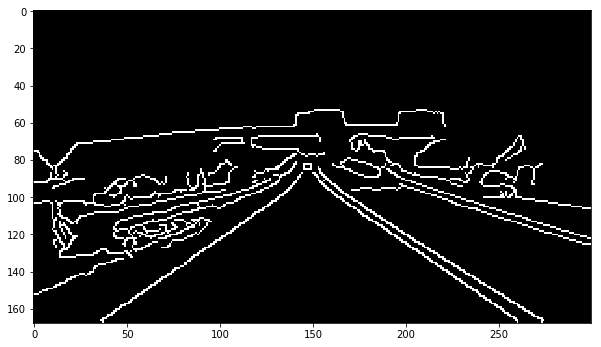

In [7]:
lane = cv2.imread('images/car_lane.jpg')
img_preprocessed  = cv2.cvtColor(cv2.GaussianBlur(lane, (7,7), 0), cv2.COLOR_BGR2GRAY)

img_edges = cv2.Canny(img_preprocessed, threshold1=20, threshold2=190)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_edges, cv2.COLOR_GRAY2RGB))

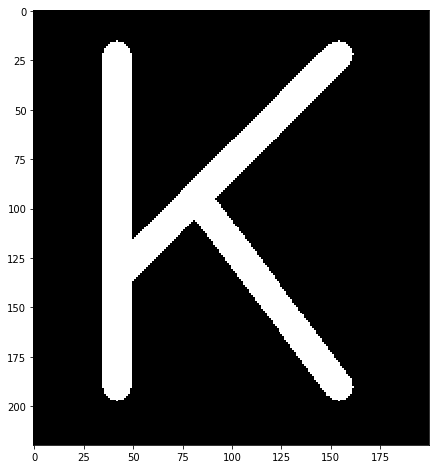

In [8]:
k_img = np.zeros((220, 200))
cv2.putText(k_img, 'K', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 8, (255, 255, 255), 14)

plt.figure(figsize=(8,8))
plt.imshow(k_img, cmap='gray')

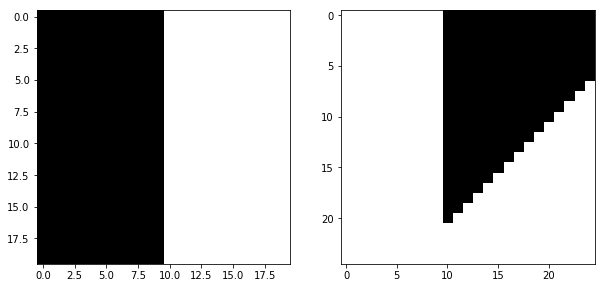

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(k_img[25:45, 25:45], cmap='gray')
axs[1].imshow(k_img[95:120, 40:65], cmap='gray')

Mathematical form of the Harris Corner detection algorithm:

![url](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/math/1948f2850c912ce3394b61ba99b546f1bf7a6adc.png)

This can be re-written as:

![url](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/math/3aea48f44ebcc36dda8055c842e209d8886d7a80.png)

And here `M` is:

![url](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/math/a33b6840bcc7c240425581fe5e39e58d868f9893.png)

Coding this function by hand is an interesting exercise but outside the scope of the course. If anyone is interested in understanding the underlying math I recommend coding it. You can find a more det use this as your guide: http://www.kaij.org/blog/?p=89

## Dilation & Erosion

In [13]:
np.random.random(k_img.shape)>0.05

array([[ True,  True, False, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True]])

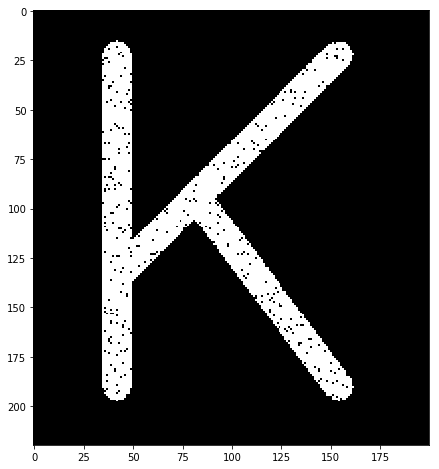

In [14]:
k_noise = (k_img/255)*(np.random.random(k_img.shape)>0.05)

plt.figure(figsize=(8,8))
plt.imshow(k_noise, cmap='gray')

Closing -> Dilation + Erosion

We will do dilation by hand by convolving a filter and and setting a pixel as 1 if at least one of the pixels in the window is 1

![Url](http://deeplearning.net/software/theano/_images/same_padding_no_strides.gif "zero padding")

In [15]:
kernel = np.ones((3,3))

no_pass = np.zeros((3,3))

pass_window = np.random.randint(0, 2, (3,3)).astype(float)

print('No pass:')
print(no_pass)
print('\nPass:')
print(pass_window)

No pass:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Pass:
[[0. 1. 1.]
 [0. 0. 0.]
 [1. 1. 0.]]


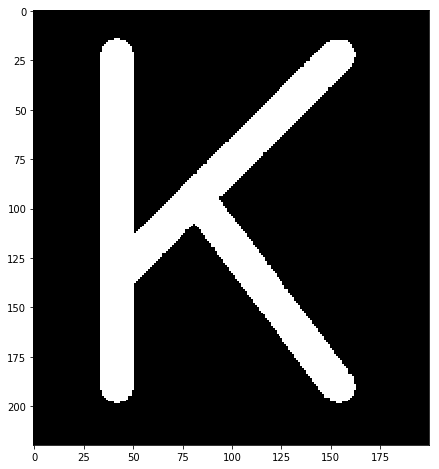

In [16]:
dilated = (cv2.filter2D(k_noise, -1, kernel) > 0.0).astype(float)

plt.figure(figsize=(8,8))
plt.imshow(dilated, cmap='gray')

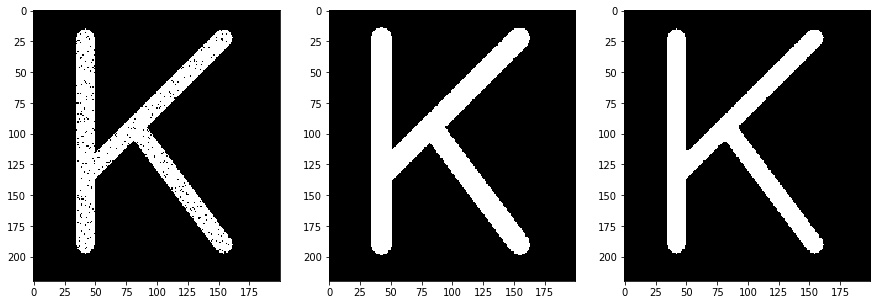

In [17]:
eroded = (cv2.filter2D(dilated, -1, kernel) > 8.0).astype(float)

fig, axs = plt.subplots(1, 3, figsize=(15,10))
axs[0].imshow(k_noise, cmap='gray')
axs[1].imshow(dilated, cmap='gray')
axs[2].imshow(eroded, cmap='gray')

### Challenge

Here we implemented the closing operation by hand, which consists of Dilation followed by Erosion.

The challenge is to manually code the opening operation, including creating the image with white noise around the object of interest.

You can find other useful morphological transformations here: 

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

## Feature vectors

### HOG

In [18]:
hog_img = np.float32(k_img)/255.0

In [19]:
gx = cv2.Sobel(hog_img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(hog_img, cv2.CV_32F, 0, 1, ksize=1)

In [20]:
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

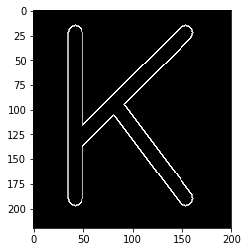

In [21]:
plt.imshow(mag, cmap='gray')

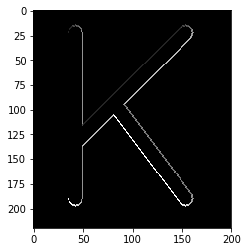

In [22]:
plt.imshow(angle, cmap='gray')

The desired image is divided into 8x8 patches

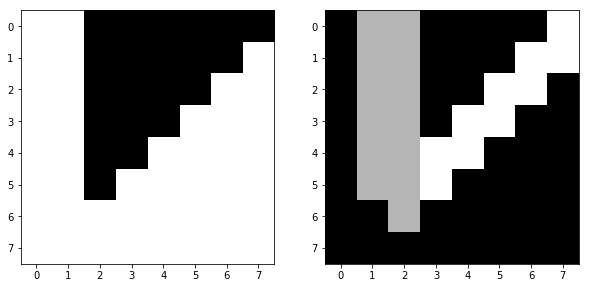

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(k_img[110:118, 48:56], cmap='gray')
axs[1].imshow(mag[110:118, 48:56], cmap='gray')

In [25]:
np.round(angle[110:118, 48:56], 2)

array([[  0.  , 180.  , 180.  ,   0.  ,   0.  ,   0.  ,   0.  ,  44.99],
       [  0.  , 180.  , 180.  ,   0.  ,   0.  ,   0.  ,  44.99,  44.99],
       [  0.  , 180.  , 180.  ,   0.  ,   0.  ,  44.99,  44.99,   0.  ],
       [  0.  , 180.  , 180.  ,   0.  ,  44.99,  44.99,   0.  ,   0.  ],
       [  0.  , 180.  , 180.  ,  44.99,  44.99,   0.  ,   0.  ,   0.  ],
       [  0.  , 180.  ,  90.  ,  44.99,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,  90.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ]],
      dtype=float32)

![url](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-histogram-1.png)

![url](https://www.learnopencv.com/wp-content/uploads/2016/12/histogram-8x8-cell.png)

Source: https://www.learnopencv.com/

Gradient magnitudes are sensitive to lighting but ideally our descriptor should be independent of these variations, so we normalize them. For this we take patches of 16x16 (4 histograms) and we normalize the values using, for example the L2 Norm.

These 4 histograms are concatenated into a 36x1 vector. Then we concatenate all of the normalized vectors of our image to get a long feature vector which we can use to compare other images with.



In [26]:
bin_n = 16 # Number of bins
bin = np.int32(bin_n*angle/(2*np.pi))

bin_cells = []
mag_cells = []

cellx = celly = 8

for i in range(0, int(hog_img.shape[0]/celly)):
    for j in range(0, int(hog_img.shape[1]/cellx)):
        bin_cells.append(bin[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])
        mag_cells.append(mag[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])   

hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
hist = np.hstack(hists)

In [27]:
hist.shape

(67675,)

In [28]:
hist[66120:66125]

array([0., 0., 9., 0., 0.])

## CNNs

Let's start very simple. We will be using dot products a lot in deep learning, why?

In [2]:
a = np.array([0, 1, 0, 1])
b = np.array([1, 0, 1, 0])
c = np.array([0, 0.5, 0.5, 0])

In [3]:
print(a.dot(b.T))
print(c.dot(b.T))
print(a.dot(a.T))

0
0.5
2


### Simple neural network in Numpy

**Music recommendation model**

- Column A: Fast -> 1, Slow -> 0
- Column B: Avicii song -> 1, Not Avicii song -> 0
- Column C: Audible -> 1, Not audible -> 0

In [8]:
data = np.array([[0, 1, 1],
                 [1, 1, 1],
                 [0, 0, 1],
                 [1, 0, 1]]) #4x3

# I liked the first and last songs
labels = np.array([[1, 0, 0, 1]]).T # 4x1

In [9]:
np.random.seed(1)

hidden_size = 4

weight01 = np.random.randn(3, hidden_size) # 3x4
weight12 = np.random.randn(hidden_size, 1) # 4x1

lr = 0.2
epochs = 80

def relu(x):
    return (x > 0) * x

def relu_deriv(output):
    return output > 0

for e in range(epochs):
    total_error = 0
    preds = []
    for idx in range(len(data)): #Stochastic Gradient Descent
        x = data[idx:idx+1] # 1x3
        hidden = relu(x.dot(weight01)) # 1x4
        pred = hidden.dot(weight12) # 1x1
        preds.append(round(float(pred), 2))
        
        delta_weight12 = pred - labels[idx:idx+1] # 1x1
        total_error += np.sum(delta_weight12**2)
        
        delta_weight01 = delta_weight12.dot(weight12.T)*relu_deriv(hidden) # 1x4
        
        weight12 -= lr*hidden.T.dot(delta_weight12)
        weight01 -= lr*x.T.dot(delta_weight01)
    
    if e % 10 == 0:
        print('Error:', total_error)
        print('Prediction:', preds)
        print()
        

Error: 15.458071428346903
Prediction: [3.25, -3.17, 0.56, 1.11]

Error: 0.32693833215288304
Prediction: [0.84, 0.32, 0.23, 0.62]

Error: 0.01870968721918521
Prediction: [0.96, 0.05, 0.11, 0.95]

Error: 0.0016545087030801757
Prediction: [0.99, 0.0, 0.04, 1.0]

Error: 0.00015040517782063527
Prediction: [1.0, 0.0, 0.01, 1.0]

Error: 1.256134264347067e-05
Prediction: [1.0, 0.0, 0.0, 1.0]

Error: 1.020830042217284e-06
Prediction: [1.0, 0.0, 0.0, 1.0]

Error: 8.230487930180172e-08
Prediction: [1.0, 0.0, 0.0, 1.0]



### Challenge:

Try to code this neural network manually from memory, without looking at my code.

### These neural networks don't work as well for us with images

![url](http://cs231n.github.io/assets/classify.png)

Source: http://cs231n.github.io

These neural networks don't scale to images, to many parameters and high risk of overfitting.

200x200x3 = 120.000 weights for each neuron

1.000 neurons = 120 million parameters!

**Challenges**:

- **Viewpoint variation** A single instance of an object can be oriented in many ways with respect to the camera.
- **Scale variation** Visual classes often exhibit variation in their size (size in the real world, not only in terms of their extent in the image).
- **Deformation** Many objects of interest are not rigid bodies and can be deformed in extreme ways.
- **Occlusion** The objects of interest can be occluded. Sometimes only a small portion of an object (as little as few pixels) could be visible.
- **Illumination conditions** The effects of illumination are drastic on the pixel level.
- **Background clutter** The objects of interest may blend into their environment, making them hard to identify.
- **Intra-class variation** The classes of interest can often be relatively broad, such as chair. There are many different types of these objects, each with their own appearance.


![url](http://cs231n.github.io/assets/challenges.jpeg)

### Solution: Weight sharing!

![Url](http://deeplearning.net/software/theano/_images/same_padding_no_strides.gif "zero padding")

**Convolutional layers can be stacked**

![url](https://cezannec.github.io/assets/cnn_intro/CNN_ex.png)

Source: https://cezannec.github.io/

Each deeper layer learns more abstract and complex representations 

![url](http://cs231n.github.io/assets/cnn/weights.jpeg)

![painting](images/original_painting.jpg "Painting")

![painting](images/kalle.jpg "Me")

![painting](images/kalle_painting.jpg "Painting")

### Convolution operation

**Wikipedia:** A convolution is a mathematical operation on two functions (f and g) to produce a third function that expresses how the shape of one is modified by the other. 

![url](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Comparison_convolution_correlation.svg/600px-Comparison_convolution_correlation.svg.png)

Mathematical form:

![url](https://wikimedia.org/api/rest_v1/media/math/render/svg/a1b9e5b39a03b7d26051d12bbfb21960bafbfeb0)

Source: https://wikimedia.org

![conv](images/convolution.jpg "C")

As a matrix multiplication:

![math](images/math.jpg)

In [33]:
A = np.array([[1,0,0],
              [1,1,0],
              [2,1,1],
              [0,2,1],
              [0,0,2]])


b = np.array([[2,-1,1]]).T

In [34]:
A.dot(b)

array([[ 2],
       [ 1],
       [ 4],
       [-1],
       [ 2]])

![conv2d](images/conv2d.jpg)